<a href="https://colab.research.google.com/github/priscillaoclark/15.773-hands-on-deep-learning/blob/main/HODL_SP25_Lec_08_Section_A_Image_Classification_with_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Handbags-Shoes Classifier with Transfer Learning - Finetune a Pretrained Vision Transformer

Credit: Some of the data preprocessing code adapted from [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?gclid=CjwKCAjw9aiIBhA1EiwAJ_GTSlKgxc4qopKHPsFWryOoTz7fvhvhzYSjEsgQ-bG1R51QSGppISywpBoClcIQAvD_BwE) by Francois Chollett

## Introduction

In this colab we will **fine tune a pretrained model (i.e., we will do Transfer Learning)** to build a highly accurate image classification model with very little data. Pretty much any consumer-facing app that uses image AI was probably built using this technique.

We also show how to use a technique called **data augmentation** to increase the size of your image dataset.

## Usual Setup

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # jax is often faster than tensorflow so let's try it!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras

keras.utils.set_random_seed(42)

## Data Preprocessing

Let's grab the shoe-handbag dataset

In [ ]:
!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip

In [ ]:
!unzip -qq handbags-shoes.zip

In [ ]:
import os, shutil, pathlib
base_dir = pathlib.Path("/content/handbags-shoes")

In [ ]:
for category in ('handbags', 'shoes'):
  fnames = os.listdir(base_dir/category)

  dir = base_dir /'train' / category
  os.makedirs(dir)
  for fname in fnames[:50]:    # the first 50 examples go into the training set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

  dir = base_dir /'validation' / category
  os.makedirs(dir)
  for fname in fnames[50:75]:  # the next 25 examples go into the validation set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

  dir = base_dir /'test' / category
  os.makedirs(dir)
  for fname in fnames[75:]:    # the remaining examples go into the test set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

The code above creates this directory structure:

train/   
..handbags/         
..shoes/    
validation/    
..handbags/       
..shoes/         
test/    
..handbags/     
..shoes/   

You can see this for yourself by clicking on the folder icon on the left nav bar.

When working with image JPEGs, we will follow this process:

1.   Read in the JPEGs
2.   Convert the JPEGs into tensors
3.   Resize them to a standard size (since web-scraped images may be in different sizes)
5.   Group them into batches (we’ll use batches of 32 images).


Fortunately, Keras gives us a single function that does all these in one shot! (Ref: [image manipulation functions](https://keras.io/api/preprocessing/image/))

In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)


Found 96 files belonging to 2 classes.
Found 49 files belonging to 2 classes.
Found 40 files belonging to 2 classes.



Is "Deep Learning" even possible with so few examples?

YES!

We will now build a near-perfect handbags vs shoes classifier using **just** these 96 training images!


Let's check the shape of each image. Since these are color images, they will have 3 channels and since we sized them to (224, 224) 👆, the shape should be (224, 224, 3).

In [ ]:
for images, _ in train_dataset.take(1):
  print(images[0].shape)

(224, 224, 3)


Nice. Lets take a peek at the images as well.

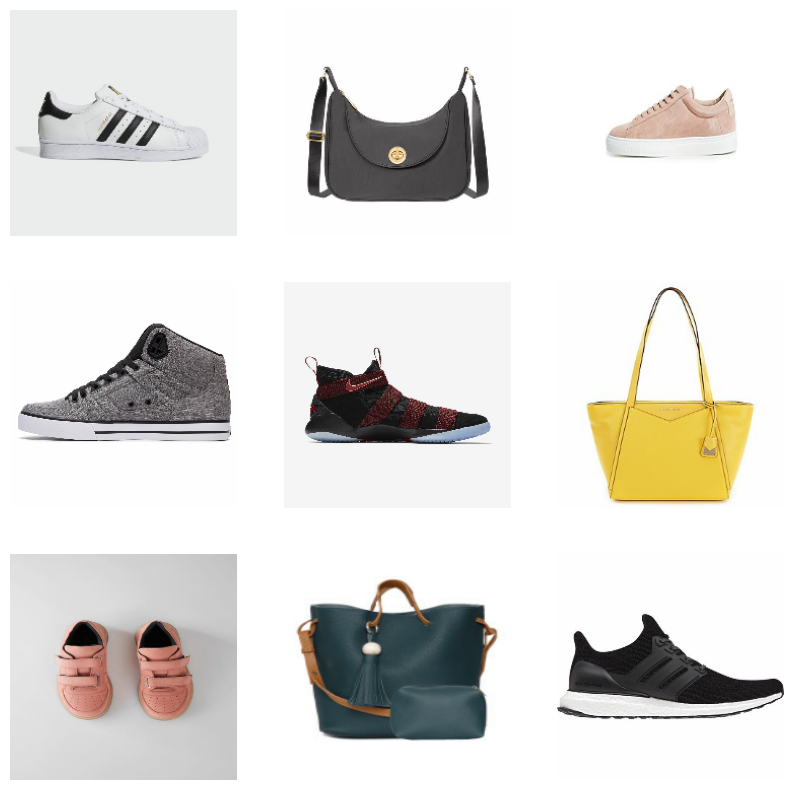

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Data Augmentation

Recall from lecture that the basic idea of augmentation is to slightly alter the image so that its meaning (e.g., the category that it belongs to) doesn't change. For instance, if you rotate the image of a handbag by 10 degrees or zoom in on it slightly, the content of the image doesn't change; it is *still* a handbag.

By applying these transformations repeatedly to an image, you can create new images and thereby increase the size of the dataset almost effortlessly.

Researchers have developed a list of these transformations that you can apply to images and Keras provides them out of the box as different kinds of *layers* See [here](https://keras.io/api/layers/preprocessing_layers/image_augmentation/) for an exhaustive list of perturbations supported by Keras.


To demonstrate, here's a little function that applies four transformations to an incoming image:
* horizontal flip
* small rotation
* small zoom-in
* small movement

In [ ]:
def augment_data(image):
  data_augmentation = keras.Sequential([
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.1),
      keras.layers.RandomTranslation(0.1, 0.1),
  ])
  return data_augmentation(image)

Let's apply it to an image from our training set to see what it produces.


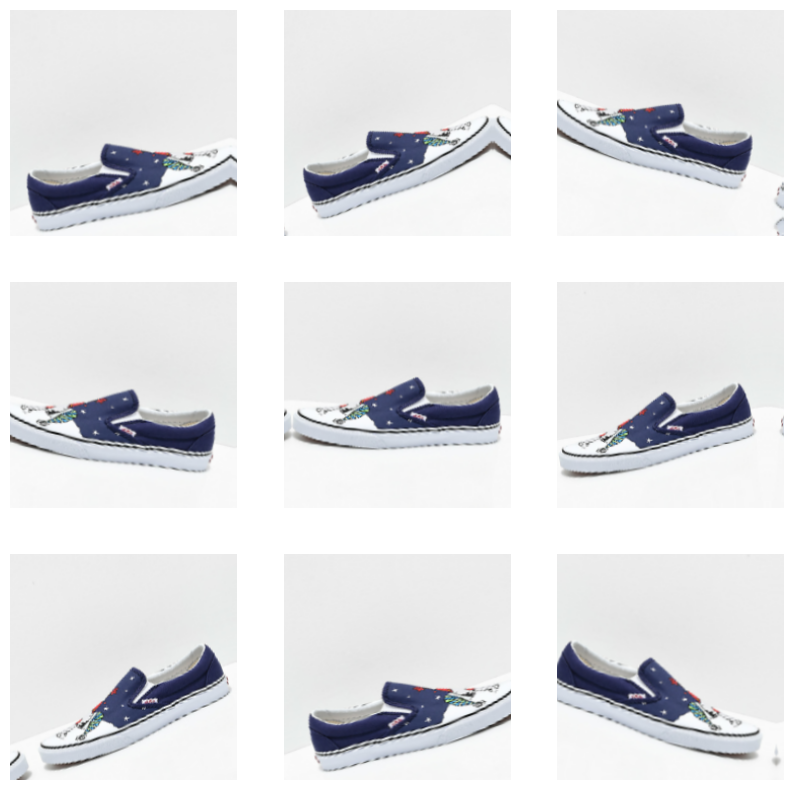

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_data(images[0])
    plt.imshow(np.array(augmented_image).astype("uint8"))
    plt.axis("off")

We will apply the data augmentations demonstrated above to our training pipeline shortly.

## Finetuning/ Transfer Learning

As described in lecture, we will work with the pre-trained [Vision Transformer (ViT)](https://www.kaggle.com/models/keras/vit) model.

(check out all the pre-trained models available on the [Keras Hub](https://www.kaggle.com/models?tfhub-redirect=true)).

The `keras_hub` that comes pre-installed colab isn't up-to-date, so let's get the current version.

In [ ]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
import keras_hub

Here is the configuration of the backbone we will be using:

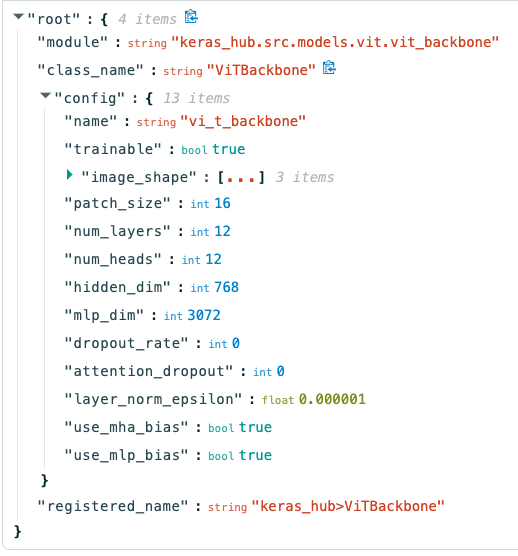

As you can see this transformer uses:
* a patch size of 16 to tokenize the images
* 12 transformer layers (or "blocks")
* 12 self-attention heads in each layer
* 3072 ReLu neurons inside the feedforward network of each Transformer block
* Embedding dimension of 768


Let's download the preprocessor and the backbone next.

In [ ]:
# We download the ViT preprocessor and the backbone

preprocessor = keras_hub.models.ViTImageClassifierPreprocessor.from_preset(
    "vit_base_patch16_224_imagenet"
)

backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")


100%|██████████| 593/593 [00:00<00:00, 991kB/s]


100%|██████████| 1.65k/1.65k [00:00<00:00, 2.20MB/s]


100%|██████████| 328M/328M [00:22<00:00, 15.6MB/s]


The preprocessor does a few things. For example:
* It resizes the images to match the size of the images on which the ViT model was pretrained
* It normalizes the pixel values to match the normalization used when the ViT model was pretrained

In this case, the preprocessor doesn't tokenize. That step will be handled by the backbone.

---

Next, we define the **data augmentation** pipeline as demonstrated earlier.


In [ ]:
# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

We can insert these  data augmentation layers right after the input layer in the model we build, and train the model. Because we have effectively more data now, we can train this data-augmented model for more epochs at a lower risk of overfitting.

Now we are ready to put our model together with these Lego blocks.

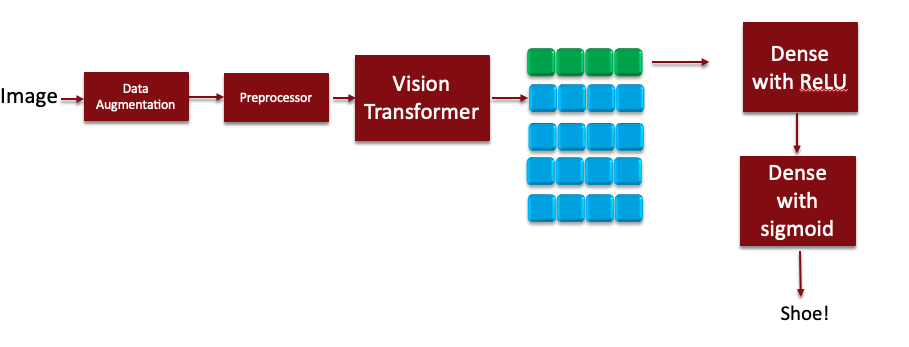

In [ ]:
inputs = keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)                             # Apply data augmentation
x = preprocessor(x)                                       # Preprocess input for ViT
x = backbone(x)[:, 0, :]                                  # Run through ViT backbone, select CLS embedding
x = keras.layers.Dense(256, activation="relu")(x)         # Run through a dense layer
outputs = keras.layers.Dense(1, activation="sigmoid")(x)  # Final binary classification layer

# Create the model
model = keras.Model(inputs, outputs)

# Summary of the model
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,995,777 (328.05 MB)

 Trainable params: 85,995,777 (328.05 MB)

 Non-trainable params: 0 (0.00 B)

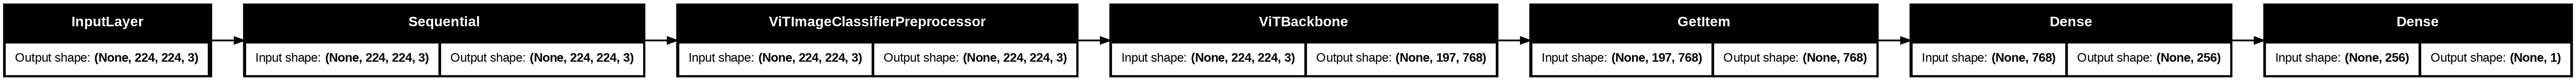

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

We will only train the projection and classifier portions of the model we just defined. We will "freeze" the weights in the backbone so that SGD/Adam won't touch them.

In [ ]:
# Freeze the backbone
backbone.trainable = False

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,995,777 (328.05 MB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

Notice the number of trainable params drops to just 197,121!

In which layers do these params "live"?

Okay, lets train this thing.

In [ ]:
# Compile the model for initial training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    batch_size=32
)

Epoch 1/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4740 - loss: 1.0966 - val_accuracy: 0.5918 - val_loss: 0.7056
Epoch 2/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 681ms/step - accuracy: 0.6198 - loss: 0.6610 - val_accuracy: 0.7755 - val_loss: 0.4511
Epoch 3/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 683ms/step - accuracy: 0.8542 - loss: 0.4077 - val_accuracy: 0.9388 - val_loss: 0.2913
Epoch 4/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.9401 - loss: 0.2650 - val_accuracy: 0.9796 - val_loss: 0.1968
Epoch 5/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 682ms/step - accuracy: 0.9740 - loss: 0.1920 - val_accuracy: 0.9796 - val_loss: 0.1394
Epoch 6/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step - accuracy: 0.9648 - loss: 0.1533 - val_accuracy: 1.0000 - val_loss: 0.1027
Epoch 7/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 670ms/step - accuracy: 1.0000 - loss: 0.0835 - val_accuracy: 1.0000 - val_loss: 0.0789


In [ ]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0737


[0.07104245573282242, 1.0]

**IMPRESSIVE ACCURACY ON THE TEST SET!!**


Let's pause for a moment to reflect on what we have done.

We have built an amazingly accurate handbags or shoes classifier with *just* 100 training images!

That's the power of transfer learning!!

## Visual Check of Predictions

OK, let's sample a few test images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


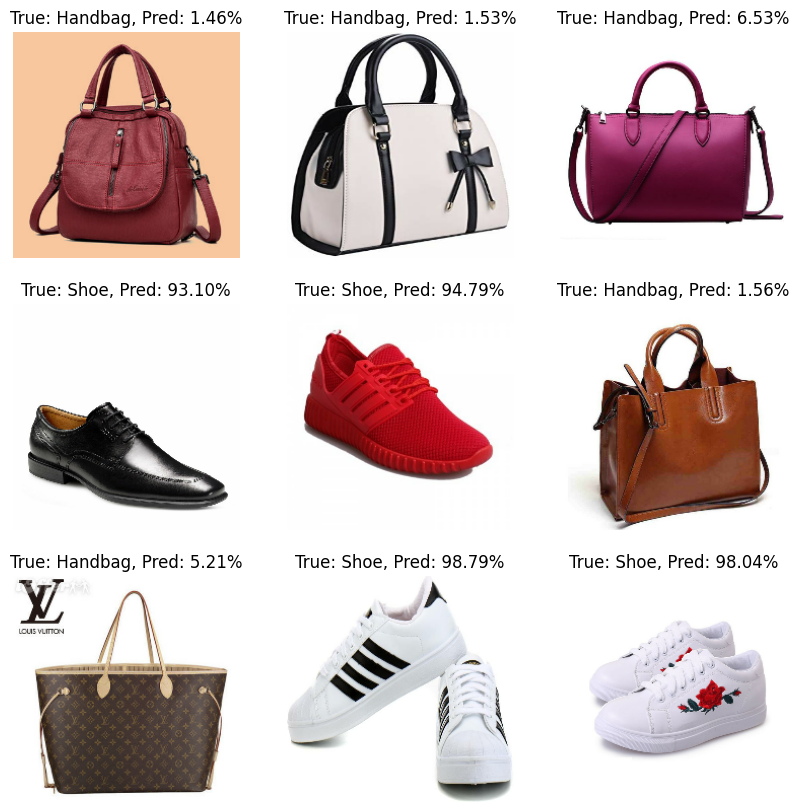

In [ ]:
label_lookup = {0: "Handbag", 1: "Shoe"}


plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  preds = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(f"True: {label_lookup[labels[i].numpy()]}, Pred: {preds[i,0]:.2%}")
    plt.axis("off")

## Live Demo 🤞

OK, let's test it **LIVE** with my laptop's webcam.

First, a little function to take in an image, run it through the model and pretty-print the result.

In [ ]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = np.expand_dims(arr, axis=0)
  pred = model.predict(arr)
  print(f"Predicted probability = {pred[0,0]:.2%}")
  pred = "SHOE" if pred[0,0] > 0.5 else "HANDBAG"
  print("************************************\n\n")
  print(f"...........it is a {pred}!")
  print("\n\n************************************\n\n")

In [ ]:
# Camera Capture code snippet courtesy Google Colab


from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



<IPython.core.display.Javascript object>

Saved to photo.jpg


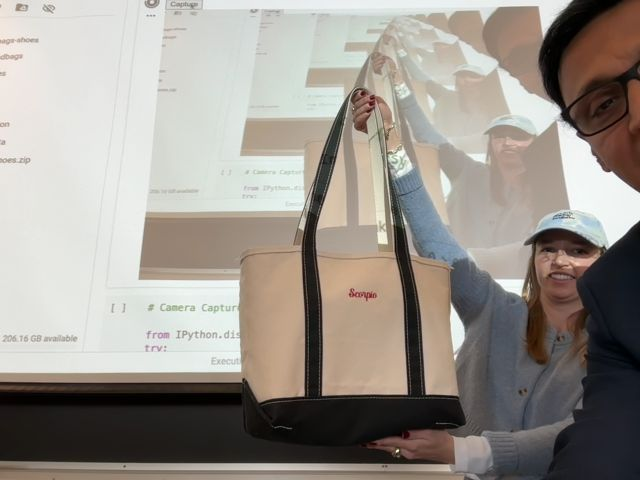

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted probability = 11.10%
************************************


...........it is a HANDBAG!


************************************




In [ ]:
# Camera Capture code snippet courtesy Google Colab

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


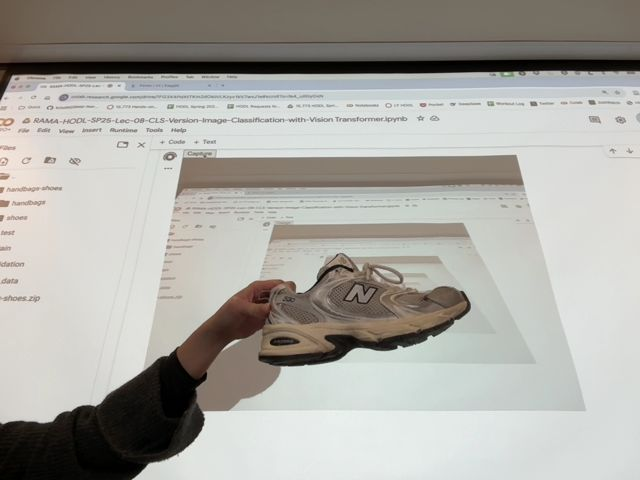

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Predicted probability = 69.32%
************************************


...........it is a SHOE!


************************************




In [ ]:
# Camera Capture code snippet courtesy Google Colab

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**THE END**